In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
import env



from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")
#import wrangle

### 1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    connection_info = f'mysql+pymysql://{user}:{password}@{host}/{db}'
    return connection_info


In [3]:
def new_zillow_data():
    '''
    This function reads the Bed/Bath count, Finished Sq Ft, Taxable Value, Year Built, and Amount Taxed
    from the 2017 Properties Zillow data from the Codeup SQL server into a df.
    '''
    sql_query = '''SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
WHERE propertylandusedesc IN ("Single Family Residential", "Inferred Single Family Residential");'''
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

In [4]:
def get_zillow_data():
    '''
    This function reads in zillow data from the Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_zillow_data()
        
        # Cache data
        df.to_csv('zillow.csv')
        
    return df

In [5]:
df = get_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


### 2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful

In [6]:
df.shape

(2152864, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 131.4 MB


In [8]:
#change column names:

df = df.rename(columns = {'bedroomcnt': 'bedrooms',
                         'bathroomcnt':'bathrooms',
                         'calculatedfinishedsquarefeet': 'square_feet',
                         'taxvaluedollarcnt': 'tax_value',
                          'taxamount': 'tax_amount',
                         'yearbuilt':'year_built'})
df.columns

Index(['bedrooms', 'bathrooms', 'square_feet', 'tax_value', 'year_built',
       'tax_amount', 'fips'],
      dtype='object')

In [9]:
df.isnull().sum()

bedrooms         11
bathrooms        11
square_feet    8485
tax_value       493
year_built     9338
tax_amount     4442
fips              0
dtype: int64

In [10]:
#regex don't understand but pulled from Adam

df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna()

In [11]:
df.isnull().sum()

bedrooms       0
bathrooms      0
square_feet    0
tax_value      0
year_built     0
tax_amount     0
fips           0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152863
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   bedrooms     float64
 1   bathrooms    float64
 2   square_feet  float64
 3   tax_value    float64
 4   year_built   float64
 5   tax_amount   float64
 6   fips         float64
dtypes: float64(7)
memory usage: 130.6 MB


In [13]:
#first changed all type to int but redo code so everything is int but taxamount
for col in df.columns[df.columns != 'taxamount']:
    df[col] = df[col].astype(int)
    

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,2140235.0,3.301419,0.932600,0.0,3.0,3.0,4.0,25.0
bathrooms,2140235.0,2.186612,0.973504,0.0,2.0,2.0,3.0,32.0
square_feet,2140235.0,1863.193970,1221.754161,1.0,1258.0,1623.0,2208.0,952576.0
tax_value,2140235.0,460641.625164,677157.635675,22.0,189166.0,328296.0,534606.0,90188462.0
year_built,2140235.0,1960.967545,22.150563,1801.0,1949.0,1958.0,1976.0,2016.0
tax_amount,2140235.0,5616.218147,7814.562814,6.0,2540.0,4111.0,6411.0,1078101.0
fips,2140235.0,6048.309556,20.344910,6037.0,6037.0,6037.0,6059.0,6111.0


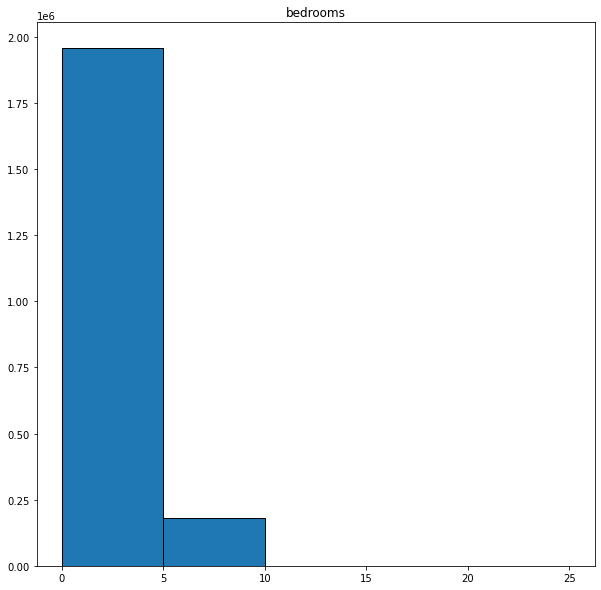

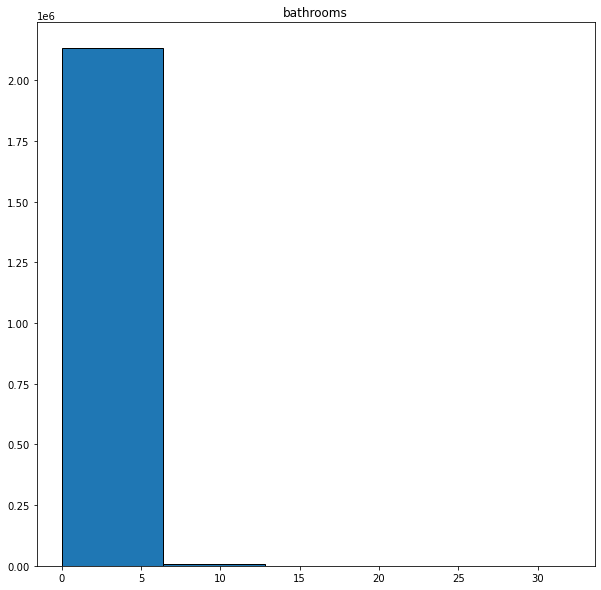

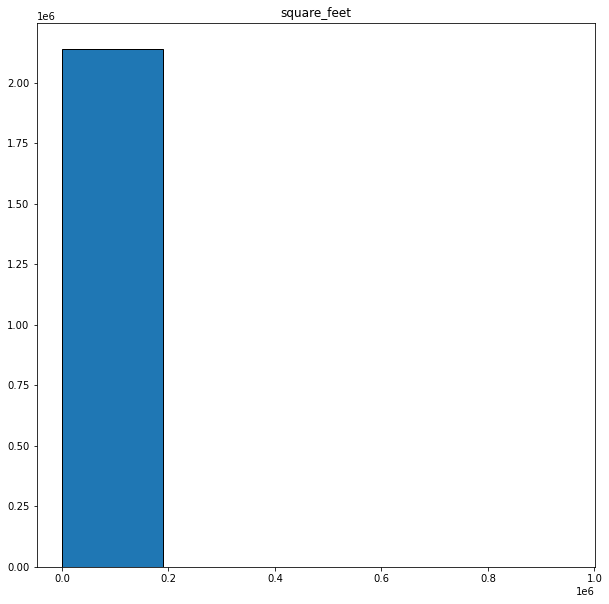

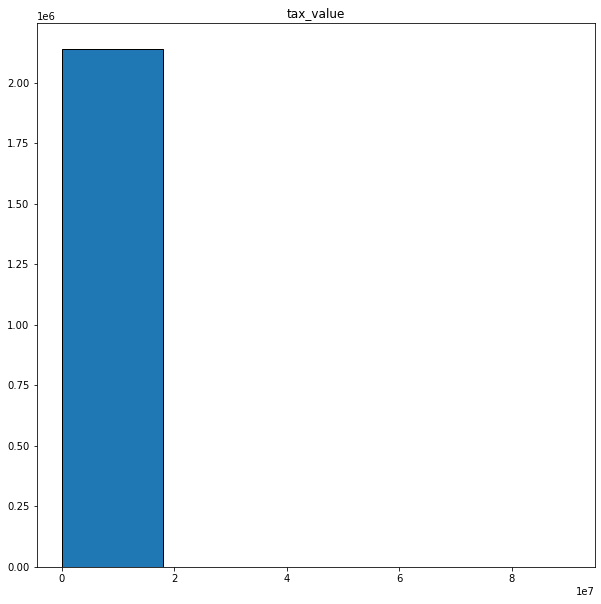

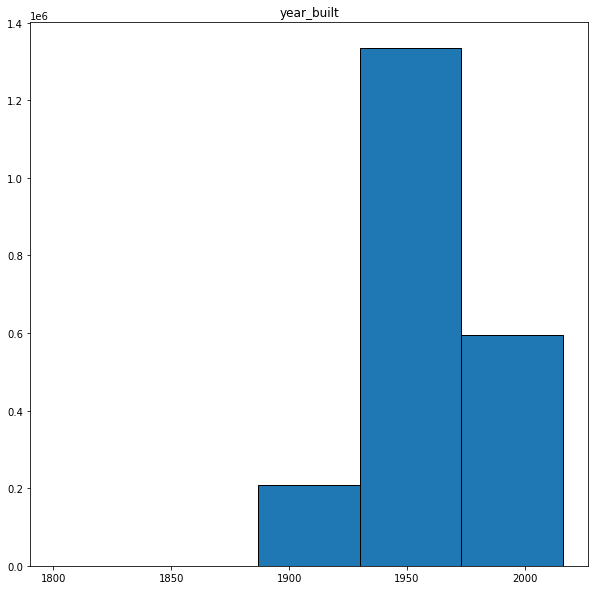

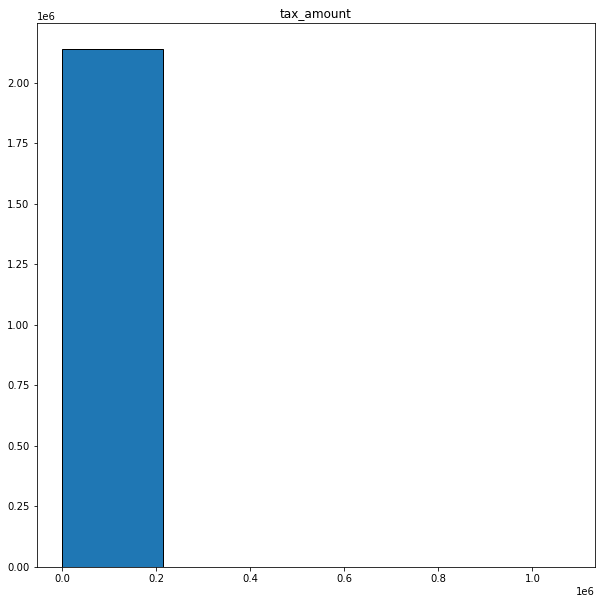

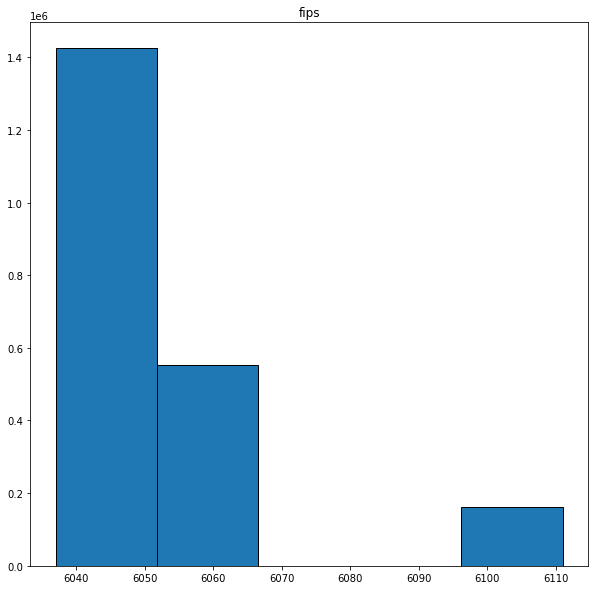

In [15]:
cols = df.columns.to_list()

for i, col in enumerate (cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.figure(figsize = (10,10))   
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(bins=5, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

In [16]:
#still need to remove outliers

In [17]:
df.shape

(2140235, 7)

In [18]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [19]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'tax_value', 'tax_amount'])
df

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
6,3,4,1620,847770,2011,10244,6037
7,3,2,2077,646760,1926,7924,6037
18,3,1,1244,169471,1950,2532,6037
19,3,2,1300,233266,1950,3110,6037
20,3,2,1222,290492,1951,3870,6037
...,...,...,...,...,...,...,...
2152854,4,2,1987,259913,1955,3175,6059
2152856,3,2,1809,405547,2012,4181,6059
2152860,4,4,3127,536061,2014,6244,6059
2152862,3,2,1974,424353,2015,5302,6059


In [20]:
df.shape

(1860336, 7)

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,1860336.0,3.217333,0.782865,2.0,3.0,3.0,4.0,5.0
bathrooms,1860336.0,2.010521,0.703864,1.0,2.0,2.0,2.0,4.0
square_feet,1860336.0,1658.388940,570.307126,1.0,1232.0,1550.0,1994.0,3454.0
tax_value,1860336.0,329056.070428,199944.077108,22.0,174291.0,297271.5,454007.0,956451.0
year_built,1860336.0,1959.515580,20.590484,1801.0,1949.0,1957.0,1972.0,2016.0
tax_amount,1860336.0,4081.218869,2252.651615,16.0,2371.0,3755.0,5503.0,10417.0
fips,1860336.0,6048.364001,20.546314,6037.0,6037.0,6037.0,6059.0,6111.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860336 entries, 6 to 2152863
Data columns (total 7 columns):
 #   Column       Dtype
---  ------       -----
 0   bedrooms     int64
 1   bathrooms    int64
 2   square_feet  int64
 3   tax_value    int64
 4   year_built   int64
 5   tax_amount   int64
 6   fips         int64
dtypes: int64(7)
memory usage: 113.5 MB


### 3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [23]:
import wrangle

In [25]:
df = wrangle.get_zillow_data()

In [27]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [ ]:
#wrote function but edited out with Adam's exercise review code - commented out beneath 

Target leakage when you have feature that represents information that cannot be known at the time for making a prediction.  Some measurement that you will only know once you have the outcome.

RESEARCH MORE

Happening lots of correlation with your target variable is a good thing.

Imputers 

def new_zillow_data(df):
    sql_query = '''
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
WHERE propertylandusedesc IN ("Single Family Residential", "Inferred Single Family Residential");
    '''
    df = pd.read_sql(sql_query, get_db_url('zillow'))
Chloe Whitaker to Everyone (12:16 PM)
That’s what I used
Joshua Wheeler to Everyone (12:16 PM)
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                       taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                WHERE propertylandusetypeid LIKE '261'
Joshua Wheeler to Everyone (12:19 PM)
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                       taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                WHERE propertylandusetypeid LIKE '261' OR '279'
Joshua Wheeler to Everyone (12:22 PM)
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                       taxvaluedollarcnt, yearbuilt, taxamount, fips, propertylandusetypeid
                FROM properties_2017
                WHERE propertylandusetypeid LIKE '261' OR propertylandusetypeid LIKE '279'
Joshua Wheeler to Everyone (12:23 PM)
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                       taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                WHERE propertylandusetypeid LIKE '261' OR propertylandusetypeid LIKE '279'
                
                
                
verbose=True
null_counts=True